In [1]:
from init import *

### Function to create an empty model
Lets introduce a function which will construct a model. We only instruct the model to generate independent gaussian random numbers, when it (later) it will be needed.

In [2]:
def create_model (t0=0,TimeSteps=10,NumPaths=1):
    model = sdk.Model()
    model.TimeStart = t0
    model.TimeSteps = TimeSteps
    model.NumPaths = NumPaths
    model.Add(sdk.IndependentGaussian())
    print(f'A model with {TimeSteps} time steps and {NumPaths} paths.')
    return model

### Rate and discount processes

In [3]:
def add_rate_and_discount_processes (
    model          : sdk.Model,
    rate_start     : float     = 0,
    rate_drift     : float     = 0,
    rate_diffusion : float     = 0,
    prefix         : str         = ''
):
    print(f'The rate process follows a BrownianMotion process starting at {rate_start} with drift={rate_drift} and diffusion={rate_diffusion} parameters.')
    rate_uf = model.Add(sdk.BrownianMotion(start=rate_start,drift=rate_drift,diffusion=rate_diffusion,title=f'{prefix}rate'))
    df_uf = model.Add(sdk.ZeroCouponBond(underlying=rate_uf.GetStateNumber(),start=1,title=f'{prefix}discount factor'))
    return {
        'rate':rate_uf,
        'df':df_uf
    }


### Function to add fixed leg into a model

In [4]:
def add_fixed_leg (
    model       : sdk.Model,
    t0          : float,
    dt          : float,
    n           : int,
    fixed_rate  : float,
    discount    : sdk.Updater,
    notional    : float       = 1,
    prefix      : str         = ''
):
    '''Add fixed leg with constant notional and rate
    
    Args:
        t0       (float): start of the leg with respect to the model start time
        dt       (float): time interval between fixed leg time points, dt>0
        n          (int): number of periods, n>0
        rate     (float): fixed rate
        notional (float): notional
    '''
    
    fixed_rate_uf = model.Add(sdk.Polynom(ref=-1,args=[fixed_rate],title=f'{prefix}fixed rate'))
    notional_uf = model.Add(sdk.Polynom(ref=-1,args=[notional],title=f'{prefix}notional'))
    tau_uf = model.Add(sdk.Polynom(ref=-1,args=[dt],title=f'{prefix}tau'))
    mul_uf = model.Add(sdk.Multiplication(refs=[uf.GetStateNumber() for uf in (fixed_rate_uf,notional_uf,tau_uf,discount)],title=f'{prefix}product'))

    t = [model.TimeStart+t0+i*dt for i in range(n+1)]
    print(f'{prefix} payment points:',t[1:])
    not_discounted_leg_uf = model.Add(sdk.SumOfFutureValues(
        state=mul_uf.GetStateNumber(),
        t=t[1:],
        title=f'{prefix}Value (not discounted)'
    ))
    
    leg_uf = model.Add(sdk.Division(
        numerator=not_discounted_leg_uf.GetStateNumber(),
        denominator=discount.GetStateNumber(),
        title=f'{prefix}Value'
    ))
    
    return {
        'time_points': t,
        'fixed_leg':leg_uf
    }

### Model with a deterministic constant rate

In [5]:
model = create_model()
add1 = add_rate_and_discount_processes(model=model,rate_start=0,rate_drift=0,rate_diffusion=0)
add2 = add_fixed_leg(model=model,t0=0,dt=0.5,n=3,fixed_rate=0.01,discount=add1['df'],notional=1,prefix='[fixed leg] ')

A model with 10 time steps and 1 paths.
The rate process follows a BrownianMotion process starting at 0 with drift=0 and diffusion=0 parameters.
[fixed leg]  payment points: [0.5, 1.0, 1.5]


In [6]:
model.evaluations.append(sdk.EvaluationPoint(model.TimeStart))
model.evaluations.append(sdk.EvaluationPoint(add2['time_points'][-1]))

In [7]:
results = sdk.run (model, server)
results.df()

,name,title,state,time,step,npaths,mean,mean_error,stddev,skewness
0,BrownianMotion,rate,1,0.0,-1,1,0.000,None,None,None
1,ZeroCouponBond,discount factor,2,0.0,-1,1,1.000,None,None,None
2,Polynom,[fixed leg] fixed rate,3,0.0,-1,1,0.010,None,None,None
3,Polynom,[fixed leg] notional,4,0.0,-1,1,1.000,None,None,None
4,Polynom,[fixed leg] tau,5,0.0,-1,1,0.500,None,None,None
5,Multiplication,[fixed leg] product,6,0.0,-1,1,0.005,None,None,None
6,SumOfFutureValues,[fixed leg] Value (not discounted),7,0.0,-1,1,0.015,None,None,None
7,Division,[fixed leg] Value,8,0.0,-1,1,0.015,None,None,None
8,BrownianMotion,rate,1,1.5,9,1,0.000,None,None,None
9,ZeroCouponBond,discount factor,2,1.5,9,1,1.000,None,None,None


In this example there are three payments of rate 0.01 (1%) over interval dt=0.5. And there is no discount (all discount factors are 1). As such, the leg value is $$PV=3 \cdot 0.1 \cdot 0.5=0.015$$ which matches the computed value.

### Model with a deterministic linear rate
If we use for the rate process $$\text{drift}=0.02$$ then we get a different result:

In [8]:
model = create_model()
add1 = add_rate_and_discount_processes(model=model,rate_start=0,rate_drift=0.02,rate_diffusion=0)
add2 = add_fixed_leg(model=model,t0=0,dt=0.5,n=3,fixed_rate=0.01,discount=add1['df'],notional=1,prefix='[fixed leg] ')
model.evaluations.append(sdk.EvaluationPoint(model.TimeStart))
model.evaluations.append(sdk.EvaluationPoint(add2['time_points'][-1]))
results = sdk.run (model, server)
results.df()

A model with 10 time steps and 1 paths.
The rate process follows a BrownianMotion process starting at 0 with drift=0.02 and diffusion=0 parameters.
[fixed leg]  payment points: [0.5, 1.0, 1.5]


,name,title,state,time,step,npaths,mean,mean_error,stddev,skewness
0,BrownianMotion,rate,1,0.0,-1,1,0.000000,None,None,None
1,ZeroCouponBond,discount factor,2,0.0,-1,1,1.000000,None,None,None
2,Polynom,[fixed leg] fixed rate,3,0.0,-1,1,0.010000,None,None,None
3,Polynom,[fixed leg] notional,4,0.0,-1,1,1.000000,None,None,None
4,Polynom,[fixed leg] tau,5,0.0,-1,1,0.500000,None,None,None
5,Multiplication,[fixed leg] product,6,0.0,-1,1,0.005000,None,None,None
6,SumOfFutureValues,[fixed leg] Value (not discounted),7,0.0,-1,1,0.014846,None,None,None
7,Division,[fixed leg] Value,8,0.0,-1,1,0.014846,None,None,None
8,BrownianMotion,rate,1,1.5,9,1,0.030000,None,None,None
9,ZeroCouponBond,discount factor,2,1.5,9,1,0.979925,None,None,None


### Adding a non-zero diffusion term to the rate process

In [9]:
model = create_model(NumPaths=1000)
add1 = add_rate_and_discount_processes(model=model,rate_start=0,rate_drift=0.02,rate_diffusion=0.1)
add2 = add_fixed_leg(model=model,t0=0,dt=0.5,n=3,fixed_rate=0.01,discount=add1['df'],notional=1,prefix='[fixed leg] ')
model.evaluations.append(sdk.EvaluationPoint(model.TimeStart))
model.evaluations.append(sdk.EvaluationPoint(add2['time_points'][-1]))
results = sdk.run (model, server)
results.df()

A model with 10 time steps and 1000 paths.
The rate process follows a BrownianMotion process starting at 0 with drift=0.02 and diffusion=0.1 parameters.
[fixed leg]  payment points: [0.5, 1.0, 1.5]


,name,title,state,time,step,npaths,mean,mean_error,stddev,skewness
0,BrownianMotion,rate,1,0.0,-1,1000,0.000000,0.000000e+00,0.000000e+00,NaN
1,ZeroCouponBond,discount factor,2,0.0,-1,1000,1.000000,0.000000e+00,0.000000e+00,NaN
2,Polynom,[fixed leg] fixed rate,3,0.0,-1,1000,0.010000,4.409235e-08,1.394323e-06,-39649.667969
3,Polynom,[fixed leg] notional,4,0.0,-1,1000,1.000000,0.000000e+00,0.000000e+00,NaN
4,Polynom,[fixed leg] tau,5,0.0,-1,1000,0.500000,0.000000e+00,0.000000e+00,NaN
5,Multiplication,[fixed leg] product,6,0.0,-1,1000,0.005000,2.204618e-08,6.971613e-07,-39649.667969
6,SumOfFutureValues,[fixed leg] Value (not discounted),7,0.0,-1,1000,0.014888,2.620074e-05,8.285400e-04,0.177405
7,Division,[fixed leg] Value,8,0.0,-1,1000,0.014888,2.620074e-05,8.285400e-04,0.177405
8,BrownianMotion,rate,1,1.5,9,1000,0.026859,3.914548e-03,1.237889e-01,0.117272
9,ZeroCouponBond,discount factor,2,1.5,9,1000,0.986216,3.151585e-03,9.966187e-02,0.191997


### Requesting to compute the fixed leg value distribution

In [10]:
model = create_model(NumPaths=100000)
add1 = add_rate_and_discount_processes(model=model,rate_start=0,rate_drift=0.02,rate_diffusion=0.5)
add2 = add_fixed_leg(model=model,t0=0,dt=0.5,n=3,fixed_rate=0.01,discount=add1['df'],notional=1,prefix='[fixed leg] ')
model.evaluations.append(
    sdk.EvaluationPoint(model.TimeStart)
        .Add(sdk.Histogram(
            ax = sdk.HistogramAxis(
                add2['fixed_leg'].GetStateNumber(),
                200
            ),
        ))                
)
model.evaluations.append(sdk.EvaluationPoint(add2['time_points'][-1]))
results = sdk.run (model, server)
results.df()

A model with 10 time steps and 100000 paths.
The rate process follows a BrownianMotion process starting at 0 with drift=0.02 and diffusion=0.5 parameters.
[fixed leg]  payment points: [0.5, 1.0, 1.5]


,name,title,state,time,step,npaths,mean,mean_error,stddev,skewness
0,BrownianMotion,rate,1,0.0,-1,100000,0.000000,0.000000,0.000000,NaN
1,ZeroCouponBond,discount factor,2,0.0,-1,100000,1.000000,0.000000,0.000000,NaN
2,Polynom,[fixed leg] fixed rate,3,0.0,-1,100000,0.010000,NaN,NaN,NaN
3,Polynom,[fixed leg] notional,4,0.0,-1,100000,1.000000,0.000000,0.000000,NaN
4,Polynom,[fixed leg] tau,5,0.0,-1,100000,0.500000,0.000000,0.000000,NaN
5,Multiplication,[fixed leg] product,6,0.0,-1,100000,0.005000,NaN,NaN,NaN
6,SumOfFutureValues,[fixed leg] Value (not discounted),7,0.0,-1,100000,0.015525,0.000014,0.004323,1.072058
7,Division,[fixed leg] Value,8,0.0,-1,100000,0.015525,0.000014,0.004323,1.072058
8,BrownianMotion,rate,1,1.5,9,100000,0.027919,0.001932,0.610906,-0.006526
9,ZeroCouponBond,discount factor,2,1.5,9,100000,1.084240,0.001719,0.543532,1.403194


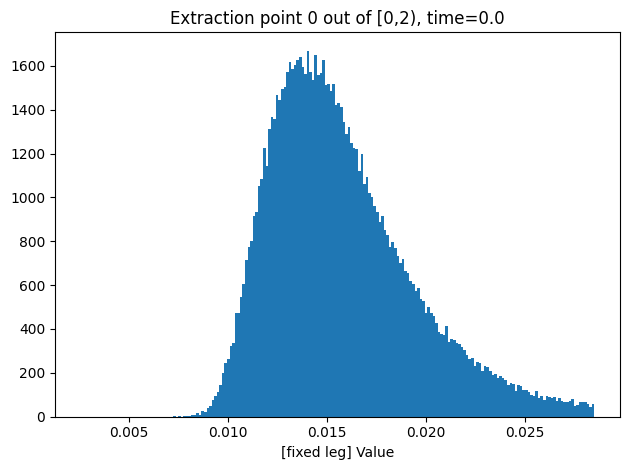

In [11]:
plot(results=results,point=0,stateX=add2['fixed_leg'].GetStateNumber())

### ... what if we use a bigger diffusion factor for the rate process

In [12]:
model = create_model(NumPaths=100000)
add1 = add_rate_and_discount_processes(model=model,rate_start=0,rate_drift=0.02,rate_diffusion=0.5)
add2 = add_fixed_leg(model=model,t0=0,dt=0.5,n=3,fixed_rate=0.01,discount=add1['df'],notional=1,prefix='[fixed leg] ')
model.evaluations.append(
    sdk.EvaluationPoint(model.TimeStart)
        .Add(sdk.Histogram(
            ax = sdk.HistogramAxis(
                add2['fixed_leg'].GetStateNumber(),
                200
            ),
        ))                
)
model.evaluations.append(sdk.EvaluationPoint(add2['time_points'][-1]))
results = sdk.run (model, server)
results.df()

A model with 10 time steps and 100000 paths.
The rate process follows a BrownianMotion process starting at 0 with drift=0.02 and diffusion=0.5 parameters.
[fixed leg]  payment points: [0.5, 1.0, 1.5]


,name,title,state,time,step,npaths,mean,mean_error,stddev,skewness
0,BrownianMotion,rate,1,0.0,-1,100000,0.000000,0.000000,0.000000,NaN
1,ZeroCouponBond,discount factor,2,0.0,-1,100000,1.000000,0.000000,0.000000,NaN
2,Polynom,[fixed leg] fixed rate,3,0.0,-1,100000,0.010000,NaN,NaN,NaN
3,Polynom,[fixed leg] notional,4,0.0,-1,100000,1.000000,0.000000,0.000000,NaN
4,Polynom,[fixed leg] tau,5,0.0,-1,100000,0.500000,0.000000,0.000000,NaN
5,Multiplication,[fixed leg] product,6,0.0,-1,100000,0.005000,NaN,NaN,NaN
6,SumOfFutureValues,[fixed leg] Value (not discounted),7,0.0,-1,100000,0.015525,0.000014,0.004323,1.072058
7,Division,[fixed leg] Value,8,0.0,-1,100000,0.015525,0.000014,0.004323,1.072058
8,BrownianMotion,rate,1,1.5,9,100000,0.027919,0.001932,0.610906,-0.006526
9,ZeroCouponBond,discount factor,2,1.5,9,100000,1.084240,0.001719,0.543532,1.403194


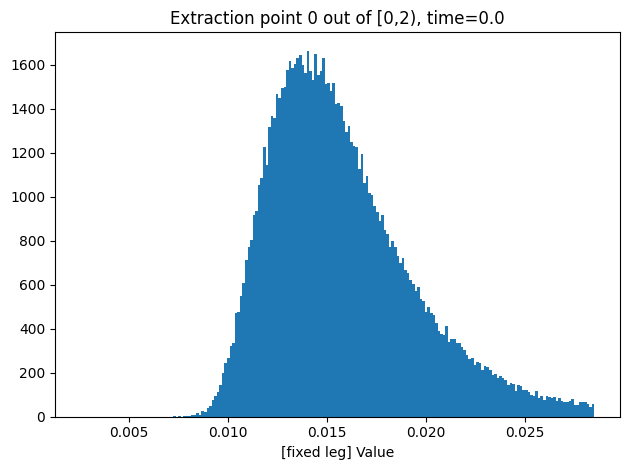

In [13]:
plot(results=results,point=0,stateX=add2['fixed_leg'].GetStateNumber())

### Use many time steps
We used only a few time steps so far. Let us use more reallistic number.

In [14]:
model = create_model(NumPaths=100000,TimeSteps=1000)
add1 = add_rate_and_discount_processes(model=model,rate_start=0,rate_drift=0.02,rate_diffusion=0.2)
add2 = add_fixed_leg(model=model,t0=0,dt=0.5,n=3,fixed_rate=0.01,discount=add1['df'],notional=1,prefix='[fixed leg] ')
model.evaluations.append(
    sdk.EvaluationPoint(model.TimeStart)
        .Add(sdk.Histogram(
            ax = sdk.HistogramAxis(
                add2['fixed_leg'].GetStateNumber(),
                200
            ),
        ))                
)
model.evaluations.append(sdk.EvaluationPoint(add2['time_points'][-1]))
results2 = sdk.run (model, server)
results2.df()

A model with 1000 time steps and 100000 paths.
The rate process follows a BrownianMotion process starting at 0 with drift=0.02 and diffusion=0.2 parameters.
[fixed leg]  payment points: [0.5, 1.0, 1.5]


,name,title,state,time,step,npaths,mean,mean_error,stddev,skewness
0,BrownianMotion,rate,1,0.0,-1,100000,0.000000,0.000000,0.000000,NaN
1,ZeroCouponBond,discount factor,2,0.0,-1,100000,1.000000,0.000000,0.000000,NaN
2,Polynom,[fixed leg] fixed rate,3,0.0,-1,100000,0.010000,NaN,NaN,NaN
3,Polynom,[fixed leg] notional,4,0.0,-1,100000,1.000000,0.000000,0.000000,NaN
4,Polynom,[fixed leg] tau,5,0.0,-1,100000,0.500000,0.000000,0.000000,NaN
5,Multiplication,[fixed leg] product,6,0.0,-1,100000,0.005000,NaN,NaN,NaN
6,SumOfFutureValues,[fixed leg] Value (not discounted),7,0.0,-1,100000,0.014977,0.000006,0.001795,0.486551
7,Division,[fixed leg] Value,8,0.0,-1,100000,0.014977,0.000006,0.001795,0.486551
8,BrownianMotion,rate,1,1.5,999,100000,0.030047,0.000774,0.244606,0.001691
9,ZeroCouponBond,discount factor,2,1.5,999,100000,1.000047,0.000676,0.213897,0.643110


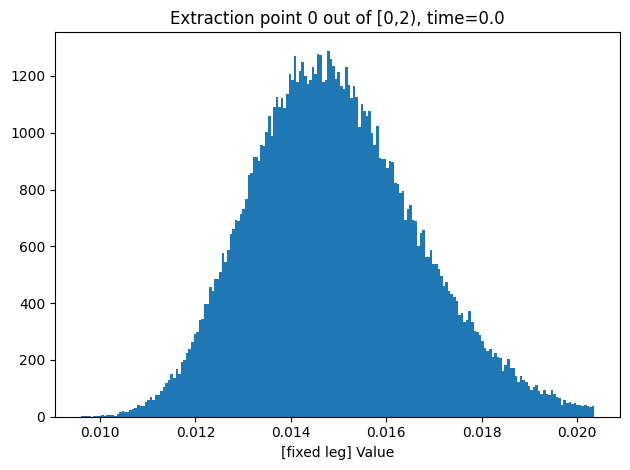

In [15]:
plot(results=results2,point=0,stateX=add2['fixed_leg'].GetStateNumber())

### What will happen if we start the swap not at the model start time, but a bit later?!

In [16]:
model = create_model(NumPaths=100000,TimeSteps=1000)
add1 = add_rate_and_discount_processes(model=model,rate_start=0,rate_drift=0.02,rate_diffusion=0.2)
add2 = add_fixed_leg(model=model,t0=2,dt=0.5,n=3,fixed_rate=0.01,discount=add1['df'],notional=1,prefix='[fixed leg] ')
for t in [model.TimeStart,add2['time_points'][0]]:
    model.evaluations.append(
        sdk.EvaluationPoint(t)
            .Add(sdk.Histogram(
                ax = sdk.HistogramAxis(
                    add2['fixed_leg'].GetStateNumber(),
                    200
                ),
            ))                
    )
model.evaluations.append(sdk.EvaluationPoint(add2['time_points'][-1]))
results = sdk.run (model, server)
results.df()

A model with 1000 time steps and 100000 paths.
The rate process follows a BrownianMotion process starting at 0 with drift=0.02 and diffusion=0.2 parameters.
[fixed leg]  payment points: [2.5, 3.0, 3.5]


,name,title,state,time,step,npaths,mean,mean_error,stddev,skewness
0,BrownianMotion,rate,1,0.0,-1,100000,0.000000,0.000000,0.000000,NaN
1,ZeroCouponBond,discount factor,2,0.0,-1,100000,1.000000,0.000000,0.000000,NaN
2,Polynom,[fixed leg] fixed rate,3,0.0,-1,100000,0.010000,NaN,NaN,NaN
3,Polynom,[fixed leg] notional,4,0.0,-1,100000,1.000000,0.000000,0.000000,NaN
4,Polynom,[fixed leg] tau,5,0.0,-1,100000,0.500000,0.000000,0.000000,NaN
5,Multiplication,[fixed leg] product,6,0.0,-1,100000,0.005000,NaN,NaN,NaN
6,SumOfFutureValues,[fixed leg] Value (not discounted),7,0.0,-1,100000,0.016557,0.000035,0.011069,2.404111
7,Division,[fixed leg] Value,8,0.0,-1,100000,0.016557,0.000035,0.011069,2.404111
8,BrownianMotion,rate,1,2.0,570,100000,0.040071,0.000894,0.282627,0.004264
9,ZeroCouponBond,discount factor,2,2.0,570,100000,1.012941,0.001072,0.338899,1.031323


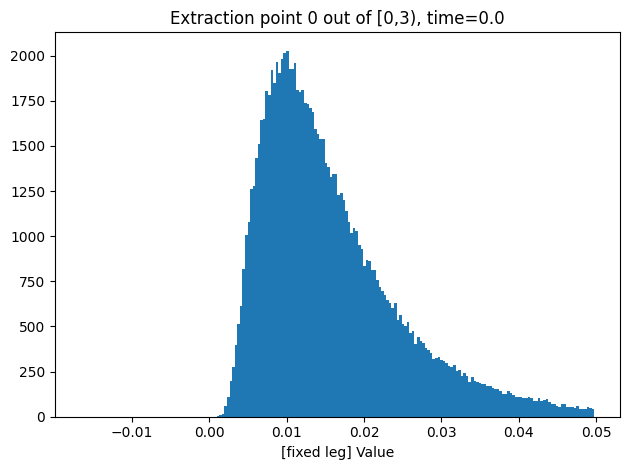

In [17]:
plot(results=results,point=0,stateX=add2['fixed_leg'].GetStateNumber())

# Fixed Leg

To value at time $t$ a swap which starts at $T_0\geq t$, last till $T_n$ we can use: 

\begin{eqnarray}
V(t) = \sum_{i=1}^n (T_i-T_{i-1})\cdot N(T_i) \cdot \frac{P_D(t,T_i)}{P_D(t,T_0)} \cdot k
\end{eqnarray}

where:
- $k$ is a fixed rate
- $P_D(\cdot)$ is a discount factor
- $N(\cdot)$ is a notional (which can be constant, time dependent or even stochastic)


# Floating Leg


The floating at time $t$ is defined as a set of payments at times $T_i$, $i=1\cdots n$ discounted to time $t$:
\begin{eqnarray}
V(t) = \sum_{i=1}^n L(T_{i-1},T_i)\cdot (T_i-T_{i-1})\cdot N(T_i) \cdot P_D(t,T_i)
\end{eqnarray}

The rate $L(t,T_{i-1},T_i)$ on each time interval $[T_{i-1},T_i]$ is computed at times points times $T_i$, $i=0\cdots n-1$ as a fair rate. Thus, for a time interval $[T_{i-1},T_i]$ the rate $L(t,T_{i-1},T_i)$ is fixed at $T_{i-1}$ and an amount $L(T_{i-1},T_i)\cdot (T_i-T_{i-1})\cdot N(T_i)$ is payed at $T_i$, where $N(T_i)$ is the notional.

The fair (or break-even) rate $L(t,T,T+\tau)$ is computed (see Anderson&Peterbarg: Interest Rate Modeling) as

\begin{eqnarray}
k = L(t,T,T+\tau) = \frac{P_L(t,T)-P_L(t,T+\tau)}{\tau P_L(t,T+\tau)}
\end{eqnarray}

<!-- In the case of $t=T$, we have:

\begin{eqnarray}
k = L(T,T+\tau) = \frac{1-P_L(T,T+\tau)}{\tau P_L(T,T+\tau)}
\end{eqnarray}

or:

\begin{eqnarray}
k = L(T_{i-1},T_i) = \frac{1-P_L(T_{i-1},T_i)}{(T_i-T_{i-1}) P_L(T_{i-1},T_i)}
\end{eqnarray}
 -->
Note: the curves $P_L(\cdot)$ and $P_D(\cdot)$ don't need to be the same!

## Monte Carlo computation

to compute a fixed leg value we need to store:
- discount factor $P_D(t,T_i)$ for time points $i=0\cdots n$

to compute a floating leg value we need to store in addition:
- discount factor $P_L(t,T_i)$ for time points $i=0\cdots n$

# Swap analytical price

For a swap with constant notional $1$:

\begin{eqnarray}
V_\text{fix} (t) &=& \frac{k}{P_D(t,T_0)} \sum_{i=1}^n (T_i-T_{i-1})\cdot P_D(t,T_i)
\\
V_\text{flt} (t) &=& \frac{1}{P_D(t,T_0)} \sum_{i=1}^m (T_i-T_{i-1})\cdot P_D(t,T_i) \cdot L(t,T_{i-1},T_i)
\\
&=& \frac{1}{P_D(t,T_0)} \sum_{i=1}^m (T_i-T_{i-1})\cdot P_D(t,T_i) \cdot \frac{P_L(t,T_{i-1})-P_L(t,T_i)}{(T_i-T_{i-1}) P_L(t,T_i)}
\\
&=& \frac{1}{P_D(t,T_0)} \sum_{i=1}^m P_D(t,T_i) \cdot \frac{P_L(t,T_{i-1})-P_L(t,T_i)}{P_L(t,T_i)}
\end{eqnarray}

###
In a single curve case (when $P_L$=$P_D$) the sum will be simplified into a difference of two discount factors and we get the famous value for a floating leg value:

\begin{eqnarray}
V_\text{flt} (t) &=& \frac{P_D(t,T_0)-P_D(t,T_m)}{P_D(t,T_0)}
\\ 
&=& 1 - \frac{P_D(t,T_m)}{P_D(t,T_0)}
\end{eqnarray}
